# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import *
from plot import plot_hist, plot_scatter
from wrangling import df_transform
from regression import simple_linear_regression, multiple_linear_regression, model_diagnostics

# Loading dataset

In [2]:
#df = pd.read_csv('/content/drive/MyDrive/mlb11.csv',index_col=0)
df = pd.read_csv(r'C:\Users\sdas\Github_DS\Moneyball_Linear_Regression\mlb11.csv',index_col=0)
df.head()

,team,runs,at_bats,hits,homeruns,bat_avg,strikeouts,stolen_bases,wins,new_onbase,new_slug,new_obs
1,Texas Rangers,855,5659,1599,210,0.283,930,143,96,0.340,0.460,0.800
2,Boston Red Sox,875,5710,1600,203,0.280,1108,102,90,0.349,0.461,0.810
3,Detroit Tigers,787,5563,1540,169,0.277,1143,49,95,0.340,0.434,0.773
4,Kansas City Royals,730,5672,1560,129,0.275,1006,153,71,0.329,0.415,0.744
5,St. Louis Cardinals,762,5532,1513,162,0.273,978,57,90,0.341,0.425,0.766


In [3]:
df.describe()

,runs,at_bats,hits,homeruns,bat_avg,strikeouts,stolen_bases,wins,new_onbase,new_slug,new_obs
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000
mean,693.600000,5523.500000,1408.900000,151.733333,0.254933,1149.600000,109.300000,80.966667,0.320467,0.398833,0.71910
std,82.479088,79.873067,87.081947,35.587612,0.012744,108.049988,29.868851,11.415305,0.013441,0.029131,0.04155
min,556.000000,5417.000000,1263.000000,91.000000,0.233000,930.000000,49.000000,56.000000,0.292000,0.348000,0.64000
25%,629.000000,5448.250000,1348.000000,118.000000,0.244750,1085.250000,89.750000,72.000000,0.311000,0.377000,0.69200
50%,705.500000,5515.500000,1394.500000,154.000000,0.253000,1140.500000,107.000000,80.000000,0.318500,0.398500,0.71600
75%,734.000000,5575.000000,1441.000000,172.750000,0.260250,1247.750000,130.750000,90.000000,0.328250,0.413000,0.73825
max,875.000000,5710.000000,1600.000000,222.000000,0.283000,1323.000000,170.000000,102.000000,0.349000,0.461000,0.81000


# Defining the metrics

- https://www.mlb.com/glossary/standard-stats/hit
- https://www.mlb.com/glossary/standard-stats/at-bat
- https://www.mlb.com/glossary/standard-stats/batting-average
- https://www.mlb.com/glossary/standard-stats/home-run
- https://www.mlb.com/glossary/standard-stats/strikeout
- https://www.mlb.com/glossary/standard-stats/stolen-base
- https://www.mlb.com/glossary/standard-stats/win
- https://www.mlb.com/glossary/standard-stats/on-base-percentage
- https://www.mlb.com/glossary/standard-stats/slugging-percentage
- https://www.mlb.com/glossary/standard-stats/on-base-plus-slugging

- *hits*: Occurs when a batter makes contact with a pitch and the batter reaches base while the hit stays in fair territory. The different types of hits are singles, doubles, triples and home runs. This does not take into account fielder's choice or errors. 
- *at_bats*: Recorded when a batter reaches base via fielder's choice, hit or an error, or when a batter is put out on a non-sacrifice. 
- *bat_avg*: Calculated by dividing a player's **hits** by total **at_bats**. The bat_avg is typically between 0 and 1 with the historical average value being around 0.25. 
- *homeruns*: When a batte hits the ball over the fence and is able to run to all four bases at their leisure as there is no threat of being thrown out. All batters on the field also receive the runs. 
- *strikouts*: The batter being called out as a result of the batter missing three consecutive pitches as long as the catcher cleanly catches all three pitches. 
- *stolen_bases*: When a runner advances to a base they are not entitled to. This can happen while a pitcher is throwing a pitch, picking up the ball or has the ball. It can also happen when the catcher is throwing the ball back to the pitcher. 
- *wins*: Awarded to the pitcher of record when their team takes the lead for good. They must have pitched at least five innings to qualify for a win. 
- *new_onbase*: Refers to how frequently a batter reaches base per plate appearance. Times on base include hits, walks and hit-by-pitches, but do not include errors, times reached on a fielder's choice or a dropped third strike.
- *new_slug*: Total number of bases a player records per at bat. Unlike on-base percentage, slugging percentage deals only with hits and does not include walks and hit-by-pitches in its equation.
- *new_obs*: OPS adds on-base percentage and slugging percentage to get one number that unites the two. It's meant to combine how well a hitter can reach base, with how well he can hit for average and for power.

# Correlation

### Plot correlation matrix

In [4]:
df.corr(method="pearson").style.background_gradient()

,runs,at_bats,hits,homeruns,bat_avg,strikeouts,stolen_bases,wins,new_onbase,new_slug,new_obs
runs,1.000000,0.610627,0.801211,0.791558,0.809986,-0.411531,0.053981,0.600809,0.921469,0.947032,0.966916
at_bats,0.610627,1.000000,0.846472,0.376515,0.755374,-0.463424,-0.107529,0.062156,0.598145,0.620277,0.627909
hits,0.801211,0.846472,1.000000,0.470838,0.987958,-0.617228,-0.126330,0.297659,0.854846,0.818238,0.850833
homeruns,0.791558,0.376515,0.470838,1.000000,0.471511,-0.170755,-0.117324,0.660614,0.616327,0.862832,0.810667
bat_avg,0.809986,0.755374,0.987958,0.471511,1.000000,-0.634814,-0.123147,0.350793,0.882302,0.828490,0.867099
strikeouts,-0.411531,-0.463424,-0.617228,-0.170755,-0.634814,1.000000,0.087642,-0.280727,-0.486880,-0.409822,-0.443975
stolen_bases,0.053981,-0.107529,-0.126330,-0.117324,-0.123147,0.087642,1.000000,-0.064594,-0.033256,-0.074128,-0.061846
wins,0.600809,0.062156,0.297659,0.660614,0.350793,-0.280727,-0.064594,1.000000,0.552278,0.614166,0.612075
new_onbase,0.921469,0.598145,0.854846,0.616327,0.882302,-0.486880,-0.033256,0.552278,1.000000,0.871865,0.937283
new_slug,0.947032,0.620277,0.818238,0.862832,0.828490,-0.409822,-0.074128,0.614166,0.871865,1.000000,0.987764


Based on the above correlation matrix, it is clear that the variables **strikeouts** and **stolen_bases** have a low correlation with runs. This makes sense as a strikeout is inversely related to the batter getting runs and stolen_bases are significantly less frequent occurrences than some of the other metrics that add to runs. 

Hence, we can drop the strikeouts and stolen_bases variables and continue the analysis with the remaining variables. 

### Drop variables with low correlation to *runs*

In [5]:
df = df.drop(['team','at_bats','strikeouts','stolen_bases','wins'],axis=1)
df.head()

,runs,hits,homeruns,bat_avg,new_onbase,new_slug,new_obs
1,855,1599,210,0.283,0.340,0.460,0.800
2,875,1600,203,0.280,0.349,0.461,0.810
3,787,1540,169,0.277,0.340,0.434,0.773
4,730,1560,129,0.275,0.329,0.415,0.744
5,762,1513,162,0.273,0.341,0.425,0.766


# EDA

### Plot histograms - *default* data

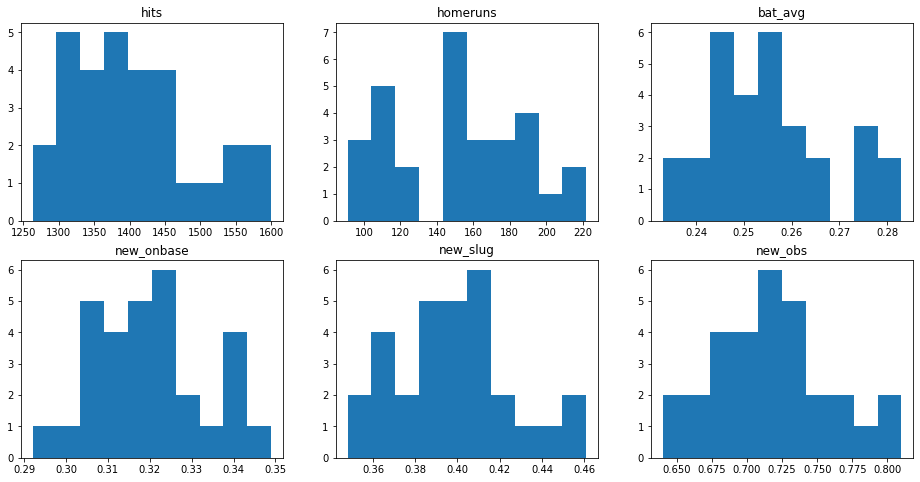

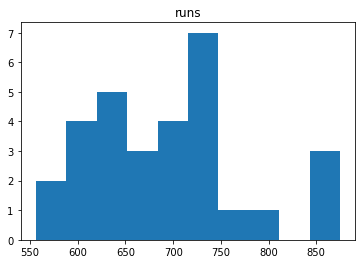

In [6]:
plot_hist(df)

### Plot histogram - *log* data

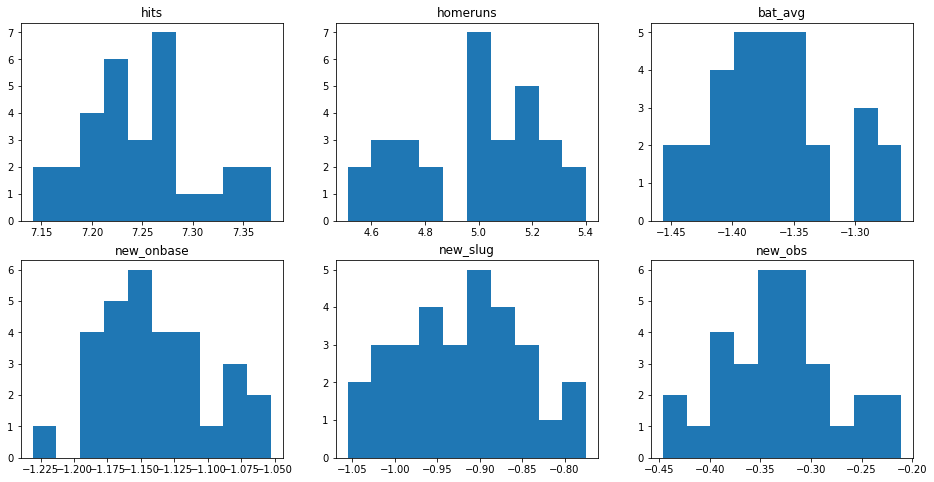

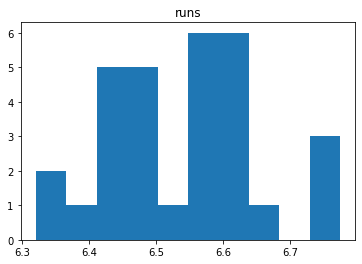

In [7]:
plot_hist(df.copy(),'log')

### Plot histogram - *square root* data

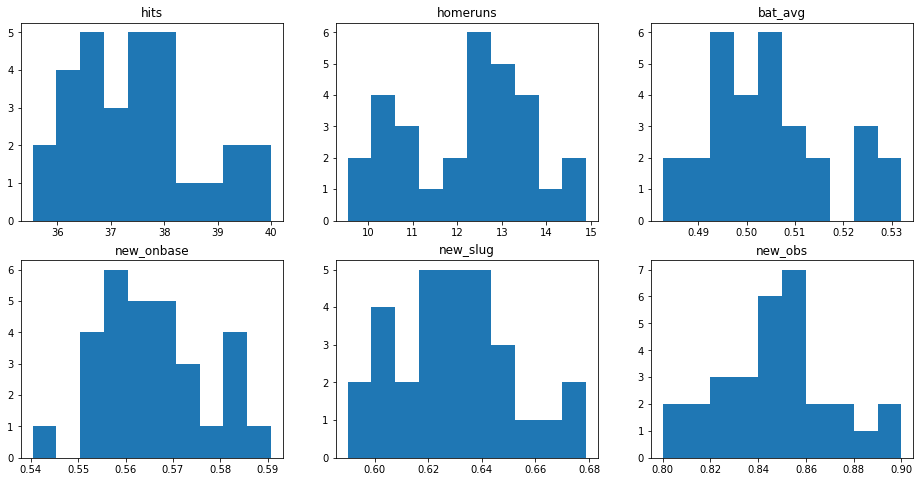

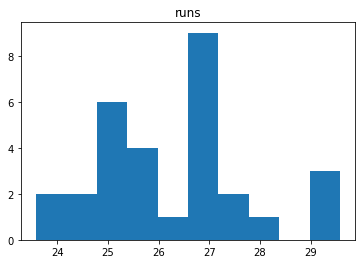

In [8]:
plot_hist(df.copy(),"root")

Plot histogram - *square* data

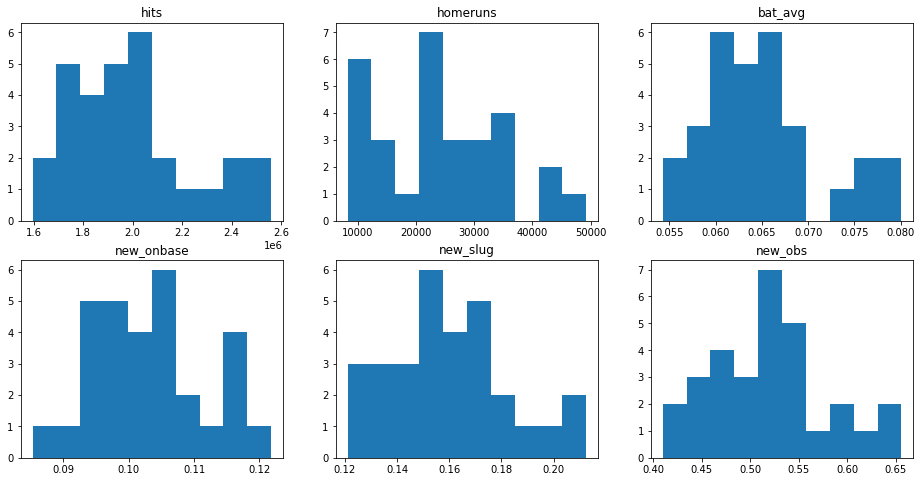

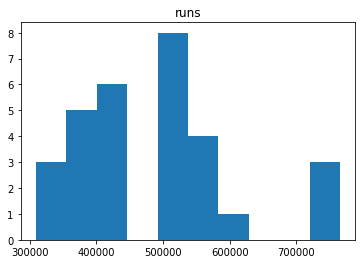

In [9]:
plot_hist(df.copy(),"square")

### Plot scatter - *default* data

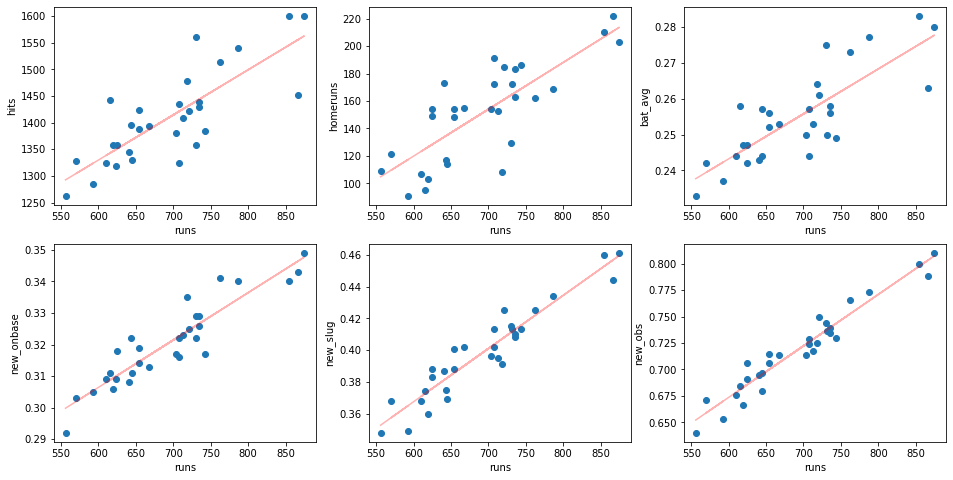

,runs,hits,homeruns,bat_avg,new_onbase,new_slug,new_obs
runs,1.000000,0.801211,0.791558,0.809986,0.921469,0.947032,0.966916
hits,0.801211,1.000000,0.470838,0.987958,0.854846,0.818238,0.850833
homeruns,0.791558,0.470838,1.000000,0.471511,0.616327,0.862832,0.810667
bat_avg,0.809986,0.987958,0.471511,1.000000,0.882302,0.828490,0.867099
new_onbase,0.921469,0.854846,0.616327,0.882302,1.000000,0.871865,0.937283
new_slug,0.947032,0.818238,0.862832,0.828490,0.871865,1.000000,0.987764
new_obs,0.966916,0.850833,0.810667,0.867099,0.937283,0.987764,1.000000


In [10]:
plot_scatter(df.copy())
df.corr(method="pearson").style.background_gradient()

### Plot scatter - *log* data

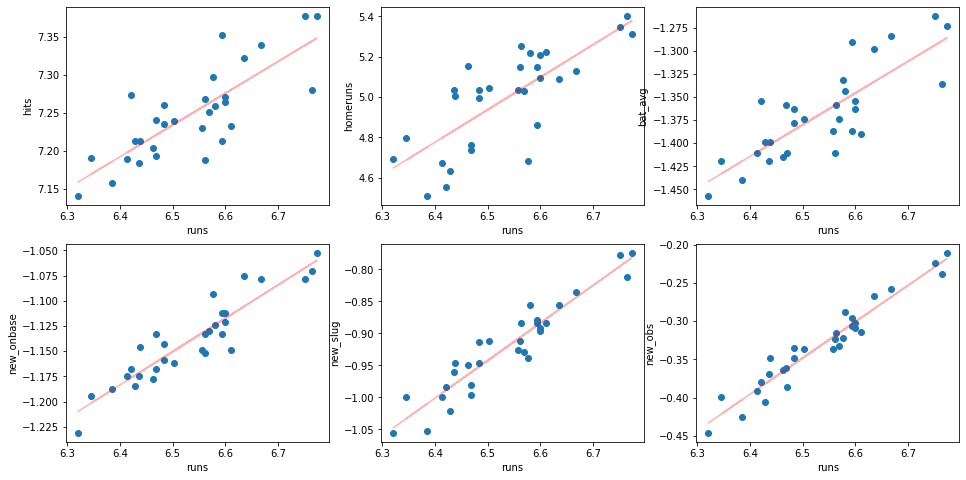

,runs,hits,homeruns,bat_avg,new_onbase,new_slug,new_obs
runs,1.000000,0.801896,0.765559,0.811187,0.923602,0.944509,0.966256
hits,0.801896,1.000000,0.456900,0.988072,0.856256,0.815886,0.850473
homeruns,0.765559,0.456900,1.000000,0.456232,0.600163,0.854989,0.799060
bat_avg,0.811187,0.988072,0.456232,1.000000,0.883530,0.825279,0.866180
new_onbase,0.923602,0.856256,0.600163,0.883530,1.000000,0.870952,0.937168
new_slug,0.944509,0.815886,0.854989,0.825279,0.870952,1.000000,0.987520
new_obs,0.966256,0.850473,0.799060,0.866180,0.937168,0.987520,1.000000


In [11]:
plot_scatter(df.copy(),"log")
df_log = df_transform(df.copy(),"log")
df_log.corr(method="pearson").style.background_gradient()

### Plot scatter - *square root* data

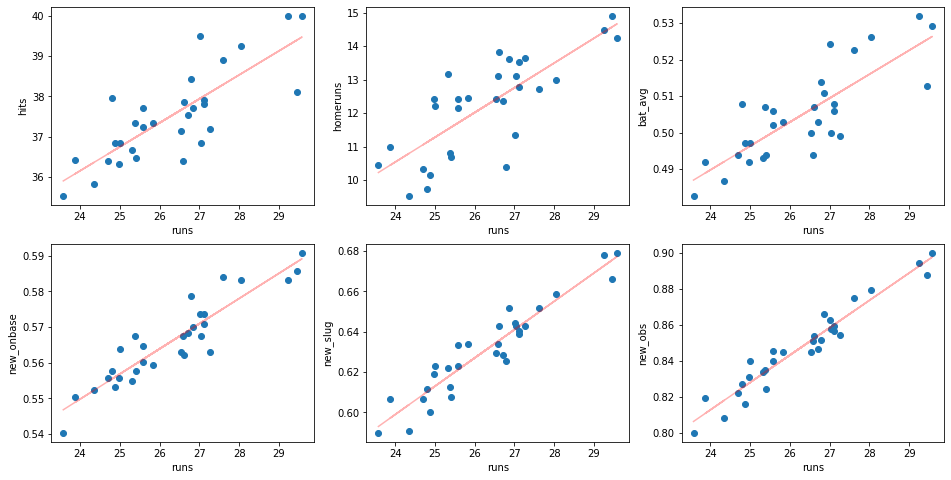

,runs,hits,homeruns,bat_avg,new_onbase,new_slug,new_obs
runs,1.000000,0.801712,0.778814,0.810805,0.922766,0.945914,0.966759
hits,0.801712,1.000000,0.464005,0.988025,0.855585,0.817011,0.850630
homeruns,0.778814,0.464005,1.000000,0.464057,0.608649,0.859526,0.805458
bat_avg,0.810805,0.988025,0.464057,1.000000,0.882937,0.826880,0.866640
new_onbase,0.922766,0.855585,0.608649,0.882937,1.000000,0.871444,0.937240
new_slug,0.945914,0.817011,0.859526,0.826880,0.871444,1.000000,0.987650
new_obs,0.966759,0.850630,0.805458,0.866640,0.937240,0.987650,1.000000


In [12]:
plot_scatter(df.copy(),"root")
df_root = df_transform(df.copy(),"root")
df_root.corr(method="pearson").style.background_gradient()

### Plot scatter - *square* data

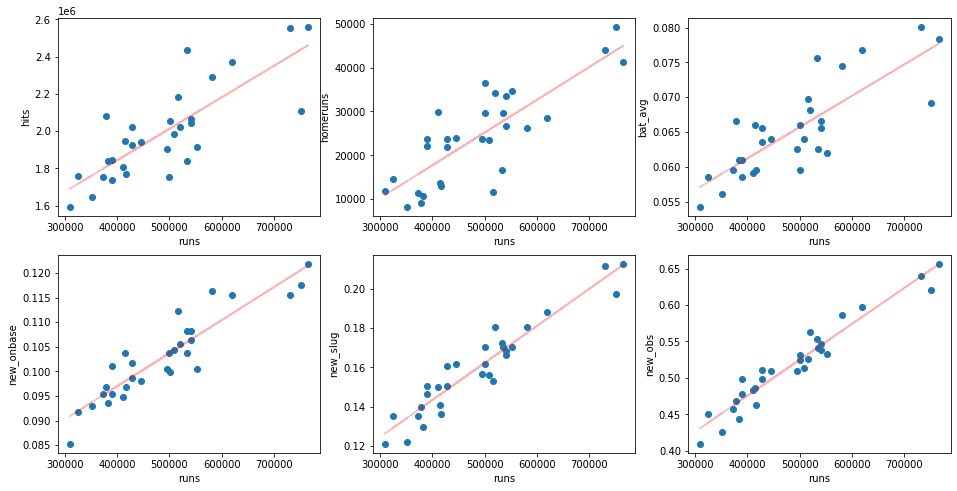

,runs,hits,homeruns,bat_avg,new_onbase,new_slug,new_obs
runs,1.000000,0.799188,0.814962,0.806960,0.917469,0.948422,0.966197
hits,0.799188,1.000000,0.482799,0.987757,0.853154,0.820966,0.851361
homeruns,0.814962,0.482799,1.000000,0.484398,0.628681,0.865289,0.816984
bat_avg,0.806960,0.987757,0.484398,1.000000,0.880893,0.831691,0.867991
new_onbase,0.917469,0.853154,0.628681,0.880893,1.000000,0.872466,0.937276
new_slug,0.948422,0.820966,0.865289,0.831691,0.872466,1.000000,0.987938
new_obs,0.966197,0.851361,0.816984,0.867991,0.937276,0.987938,1.000000


In [13]:
plot_scatter(df.copy(),"square")
df_square = df_transform(df.copy(),"square")
df_square.corr(method="pearson").style.background_gradient()

# Modeling - Simple Linear Regression

### Runs vs hits

Equation: runs ~ hits 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     50.20
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           1.04e-07
Time:                        20:06:20   Log-Likelihood:                -159.03
No. Observations:                  30   AIC:                             322.1
Df Residuals:                      28   BIC:                             324.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -375.5600    151

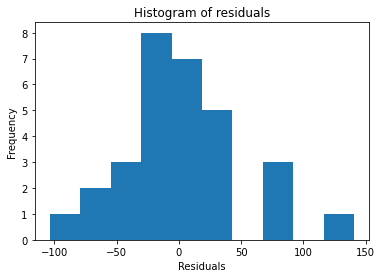

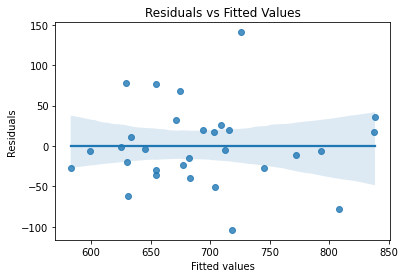

In [14]:
model = simple_linear_regression(df,'hits','runs')
model_diagnostics(model)

### Runs vs homeruns

Equation: runs ~ homeruns 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     46.98
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           1.90e-07
Time:                        20:06:21   Log-Likelihood:                -159.66
No. Observations:                  30   AIC:                             323.3
Df Residuals:                      28   BIC:                             326.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    415.2389   

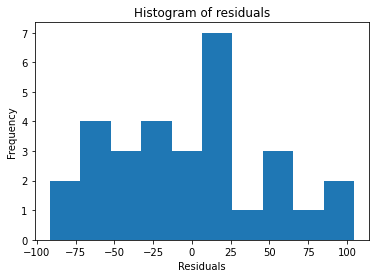

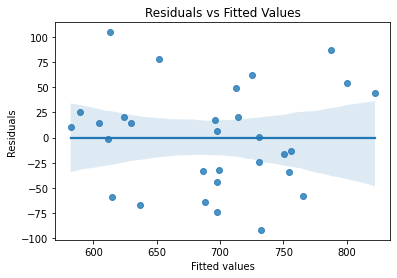

In [15]:
model = simple_linear_regression(df,'homeruns','runs')
model_diagnostics(model)

### Runs vs bat_avg

Equation: runs ~ bat_avg 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     53.41
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           5.88e-08
Time:                        20:06:21   Log-Likelihood:                -158.43
No. Observations:                  30   AIC:                             320.9
Df Residuals:                      28   BIC:                             323.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -642.8189    

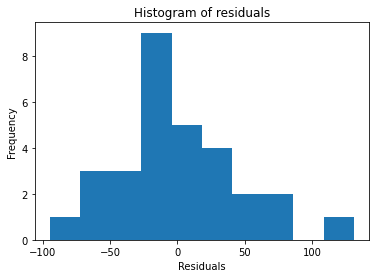

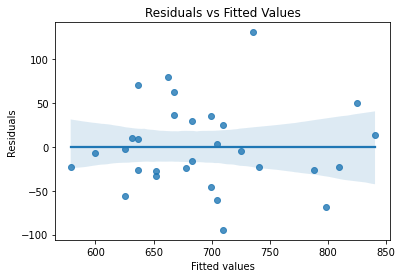

In [16]:
model = simple_linear_regression(df,'bat_avg','runs')
model_diagnostics(model)

### Runs vs new_onbase

Equation: runs ~ new_onbase 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     157.6
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           5.12e-13
Time:                        20:06:21   Log-Likelihood:                -146.07
No. Observations:                  30   AIC:                             296.1
Df Residuals:                      28   BIC:                             298.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1118.4198 

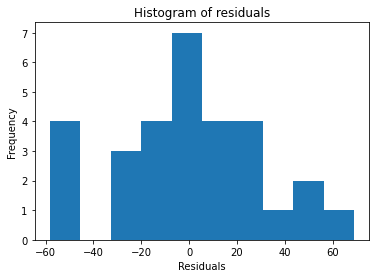

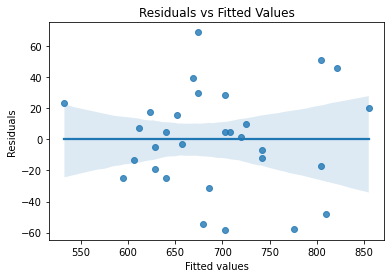

In [17]:
model = simple_linear_regression(df,'new_onbase','runs')
model_diagnostics(model)

### Runs vs new_slug

Equation: runs ~ new_slug 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     243.5
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           2.42e-15
Time:                        20:06:22   Log-Likelihood:                -140.36
No. Observations:                  30   AIC:                             284.7
Df Residuals:                      28   BIC:                             287.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -375.8041   

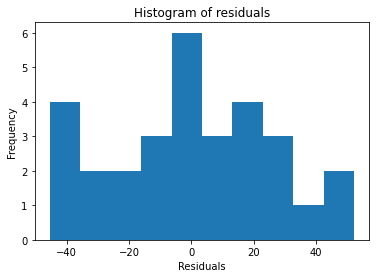

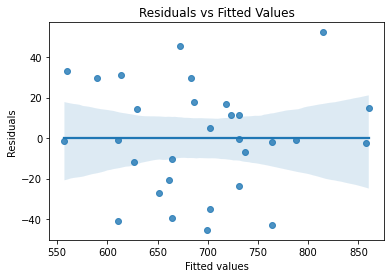

In [18]:
model = simple_linear_regression(df,'new_slug','runs')
model_diagnostics(model)

### Runs vs new_obs

Equation: runs ~ new_obs 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     402.3
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           3.76e-18
Time:                        20:06:22   Log-Likelihood:                -133.45
No. Observations:                  30   AIC:                             270.9
Df Residuals:                      28   BIC:                             273.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -686.6143    

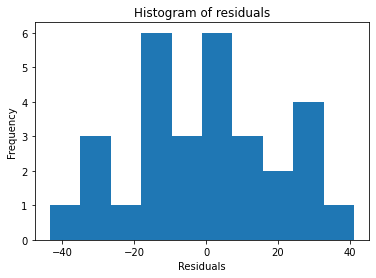

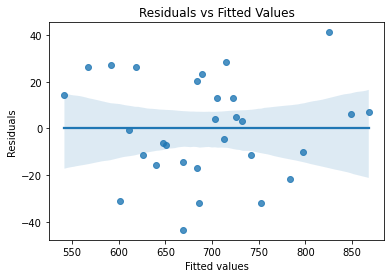

In [19]:
model = simple_linear_regression(df,'new_obs','runs')
model_diagnostics(model)

Best explanatory variables based on R-squared value: 
- *new_obs*: 0.937
- *new_slug*: 0.897
- *new_onbase*: 0.849
- *bat_avg*: 0.656
- *homeruns*: 0.627
- *hits*: 0.642

Based on these results, we can clearly see that the 3 new variables perform significantly better than the original ones. 

# Modeling - Multiple Linear Regression

### All variables

Equation: runs ~ new_obs + new_slug + new_onbase + bat_avg + homeruns + hits 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     73.89
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           7.17e-14
Time:                        20:06:22   Log-Likelihood:                -129.30
No. Observations:                  30   AIC:                             272.6
Df Residuals:                      23   BIC:                             282.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

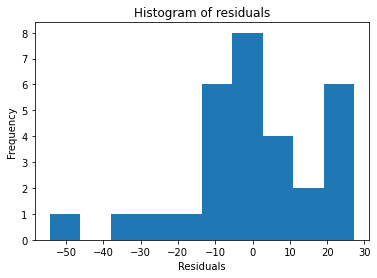

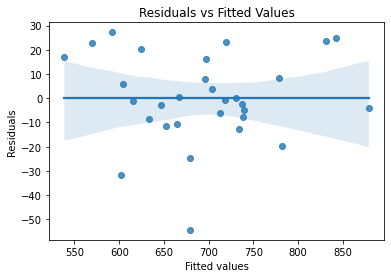

In [20]:
model = multiple_linear_regression(df,['new_obs','new_slug','new_onbase','bat_avg','homeruns','hits'],'runs')
model_diagnostics(model)

### Only high correlation variables

Equation: runs ~ new_obs + new_slug + new_onbase 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     139.5
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           3.82e-16
Time:                        20:06:23   Log-Likelihood:                -131.86
No. Observations:                  30   AIC:                             271.7
Df Residuals:                      26   BIC:                             277.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

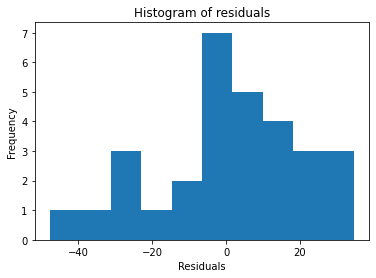

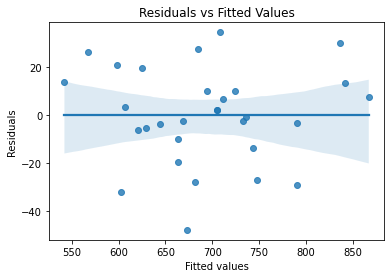

In [21]:
model = multiple_linear_regression(df,['new_obs','new_slug','new_onbase'],'runs')
model_diagnostics(model)

Since the three highly correlated variables are all well correlated with each other as well, it could possibly lead to multicollinearity. Therefore, it is probably best to include just one of these variables in the model. 

### Including *new_obs* plus the lesser correlated variables

Equation: runs ~ new_obs + bat_avg + homeruns + hits 

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     107.2
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           2.36e-15
Time:                        20:06:23   Log-Likelihood:                -130.96
No. Observations:                  30   AIC:                             271.9
Df Residuals:                      25   BIC:                             278.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

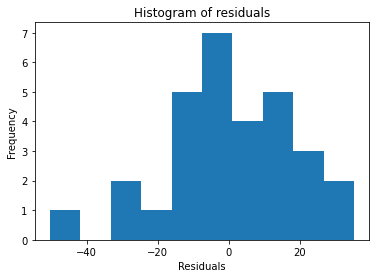

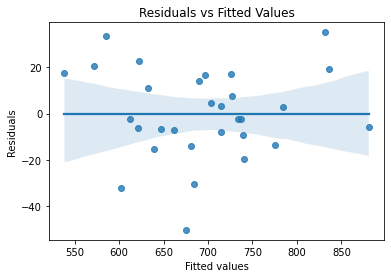

In [22]:
model = multiple_linear_regression(df,['new_obs','bat_avg','homeruns','hits'],'runs')
model_diagnostics(model)

# Next steps

- Add more diagnostics 
- Try different transformations

### 